# Import required modules

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import data
import skimage
from skimage.filters.thresholding import threshold_li,threshold_local,threshold_otsu
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, remove_small_objects
from skimage.morphology import disk
from scipy import ndimage as ndi
import sys,os, glob

#import skimage.filters.median

#import skimage.segmentation as seg
#import skimage.filters as filters
#import skimage.draw as draw
#import skimage.color as color

#from skimage.filters.thresholding import _cross_entropy
#from skimage.morphology import black_tophat, skeletonize, convex_hull_image


#pip install nd2reader_required for nd2 file reading
from nd2reader import ND2Reader

import pandas as pd

# Define parameters for image loading here:

In [8]:
# Common parameters for loading the image files of interest

# for 4 channels nd2 images: channel index order is 1-2-3-4, which is the order as ch405-ch488-ch560-ch647


# analysis done
num_of_ch = 4

# Replace protein/dna label name in the "xxx" below for the indicated channel index (make sure the order is correct)
# For example: ch_dict = {"dna":1,"rpa/rpa2":2,"mdc1":3,"pol2S5":4} if rpa/rpa2 was used for ch488
# Make sure the label name is the same as the factor/dna key used in the line below
ch_dict = {"dna":1,"Mdc1":2,"53BP1":3,"Pol2Se":4}

# If use mdc1 as the factor for region segementation
# If use dna/dapi as the key channel for nucleus segmentation
mdc1_key =  "Mdc1"
dna_key = 'dna'  # temporary fix since DNA is not good
h2ax_key="53BP1"
pol2_key = 'Pol2Se'



# Replace the data directory in the ""; * is the final path level where images are located
# For example: data_save_folder = r"F:\XXX\AAA\BBB\*"
data_save_folder = r"D:\Analyzed_CellBio\Stam\cov4_Mdc1-488 53BP1-568 PolS5-647\*"

data_files = [file for file in glob.glob(data_save_folder) if 'nd2' in file]
data_files

['D:\\Analyzed_CellBio\\Stam\\cov4_Mdc1-488 53BP1-568 PolS5-647\\cov4_Mdc1-488 53BP1-568 PolS5-647_.nd2',
 'D:\\Analyzed_CellBio\\Stam\\cov4_Mdc1-488 53BP1-568 PolS5-647\\cov4_Mdc1-488 53BP1-568 PolS5-647_001.nd2']

In [9]:
# bool setting for adjusting code indendation
_analyze_all_nd = True


# print progress
_verbose = True


# bad fovs to exclude
#fov_to_exclude = [7-1, 19-1]

fov_to_exclude_dict = {1:[24,25,48,51,55,56]}

# The pixel size for excluding small 53BP_body;
# Replace *300* with other number desired or *0* if do not want to perform 53BP1 body foci exclusion
#small_53BP_size = 300
# other parameteres for image analysis


small_53BP_size = 0

h2ax_border_size_filter = 1

#nuclei_filter = 5000 # for 1004

nuclei_filter = 600

iqr_ratio = 2

std_ratio = 3

#coord_dist = 75
#cell_size =400

po2_neg_percentile = 10


search_xylim = [300,1700]  # Note that DNA channel is not evenly illuminated

In [59]:
images = ND2Reader(data_files[2])

'v' in images.sizes.keys()

False

# Analyze each fovs and cells

In [35]:
measurement_for_all_fov_df = pd.DataFrame()

for data_ind, data in enumerate(data_files[:]):
    
    #measurement_for_all_fov = []
    
    data_name = data.split('\\')[-1]
    
    # load data of interest from preprocessed cell_info_dict
    #if data_name in cell_info_dict.keys():
    if _analyze_all_nd:
        if _verbose:
            print(f"-- Start analyzing the dataset of {data_name}")
        
        images = ND2Reader(data)
        num_of_planes = images.sizes["z"]
        
        # multi-fov image
        if 'v' in images.sizes.keys():
            num_of_fov = images.sizes["v"]
        # single fov image
        else:
            num_of_fov = 1
        
        # exclude the focal plane that are not focused
        fovs_all = list(range(num_of_fov))
        if data_ind in fov_to_exclude_dict.keys():
            fov_of_interest = [ind for ind in fovs_all if ind not in fov_to_exclude_dict[data_ind]]
        else:
            fov_of_interest = fovs_all
        
    #####################################################################################
        # going through all fov of interest
        for _fov_id in fov_of_interest[:]: 
        
            # Find the best focal plane using the mdc1 (the factor key) channel   
            image_fl = []
            image_std = []
            for i in range(num_of_planes):
                # going through all focal planes 
                image_array = np.array(images.get_frame_2D (v=_fov_id, c= ch_dict[mdc1_key], z=i))
                _fl=image_array.flatten()
                image_fl.append(_fl)
                image_std.append(np.std(_fl))
            best_plane_index = np.argmax(np.array(image_std))
            if _verbose:
                print(f"-- Analyzing the plane {best_plane_index+1} for the image {_fov_id+1} in this dataset")
                
            # load the best focal plane
            img_1_bf=np.array(images.get_frame_2D (v=_fov_id, c= 0, z=best_plane_index))
            img_2_bf=np.array(images.get_frame_2D (v=_fov_id, c= 1, z=best_plane_index))
            img_3_bf=np.array(images.get_frame_2D (v=_fov_id, c= 2, z=best_plane_index))
            img_4_bf=np.array(images.get_frame_2D (v=_fov_id, c= 3, z=best_plane_index))
            
            if _analyze_all_nd:
                # Update/Generate the img_dict
                #ch_img_dict={'1':crop_img_1,'2':crop_img_2,'3':crop_img_3,'4':crop_img_4}
                ch_img_dict={'1':img_1_bf,'2':img_2_bf,'3':img_3_bf,'4':img_4_bf}
                

                # Use Li_global_th and binary operations on the dna (POL2) channel to generate nuclei masks
                li_value =  threshold_otsu (ch_img_dict[str(ch_dict[pol2_key])])
                nuclei_mask = ch_img_dict[str(ch_dict[pol2_key])]>li_value
                
                erosion_factor_dna = 3
                eroded_nuclei_mask = dilation(nuclei_mask, disk(erosion_factor_dna))
                eroded_nuclei_mask = erosion(eroded_nuclei_mask, disk(erosion_factor_dna))
                
                eroded_nuclei_mask = ndi.binary_fill_holes(eroded_nuclei_mask)
                eroded_nuclei_mask = remove_small_objects(eroded_nuclei_mask, nuclei_filter,connectivity=1)
                smoothed_nuclei_mask = skimage.filters.median (eroded_nuclei_mask, disk(10))
                
                
                # Generate mask for the non-cell/non-nuclei background
                noncell_background = erosion(smoothed_nuclei_mask==0,disk(10))
                    
                # Nuclei segmentation to get all valid nuclei of interest
                labeled_nuclei, num_of_nuclei = ndi.label(smoothed_nuclei_mask)
                
                # Prepare to analyze cell
                kept_nuclei_info = []
                for i in range(num_of_nuclei):
                    cand_nucleus = labeled_nuclei == i+1
                    cand_nucleus[cand_nucleus>0]=1
                    cand_nucleus = np.array(cand_nucleus)
                    
                    # find the labeled nuclei close enough to the given coord (with 50 pixel)
                    region = skimage.measure.regionprops (skimage.measure.label(cand_nucleus))[0]
                    if region.centroid[0] > search_xylim[0] and region.centroid[0] < search_xylim[1]:
                        if region.centroid[1] > search_xylim[0] and region.centroid[1] < search_xylim[1]:
                            cell_xy = np.array([region.centroid[0],region.centroid[1]])
                            kept_nuclei_info.append([cand_nucleus,cell_xy])
                
                
                # Analyze each valid nuclei   
                for _cell_id, kept_nucleus_info in enumerate(kept_nuclei_info):
                        
                        
                    measurement_list = []    
                        
                    nuclei_to_measure = erosion(kept_nucleus_info[0], disk(3))
                    sel_nuclei_xy = kept_nucleus_info[1]
         
                    # Get cellular mdc mask 
                    mdc_intensity = (ch_img_dict[str(ch_dict[mdc1_key])])*nuclei_to_measure
                    mdc_intensity_filtered = mdc_intensity[mdc_intensity!=0]
                    mdc_positive_th =np.mean(mdc_intensity_filtered) + np.std(mdc_intensity_filtered)*std_ratio
                    mdc_mask = np.logical_and(ch_img_dict[str(ch_dict[mdc1_key])]>mdc_positive_th, nuclei_to_measure)
                    if small_53BP_size == 0:
                        small_53BP_size = 30
                    mdc_chr_mask = remove_small_objects(mdc_mask, small_53BP_size,connectivity=1)
                    
                    # Proceed if has MDC-positive foci
                    if np.sum(mdc_chr_mask)>=small_53BP_size:
                        
                        if _verbose:
                            print(f'-- Measuring cell {_cell_id+1} in fov {_fov_id+1}.')

                        # Generate masks for H2AX bright foci similarly but within the mdc-chr mask
                        h2ax_intensity = ch_img_dict[str(ch_dict[h2ax_key])]*nuclei_to_measure
                        h2ax_intensity_filtered = h2ax_intensity[h2ax_intensity!=0]
                        h2ax_positive_th = np.mean(h2ax_intensity_filtered) + 3* np.std(h2ax_intensity_filtered)
                        h2ax_foci_mask = np.logical_and((ch_img_dict[str(ch_dict[h2ax_key])] > h2ax_positive_th),mdc_chr_mask)
            
                        # mask for h2ax negative area within the incorporated chr; 
                        # note that border will counted for both so the add-up is bit larger than the incorporated chr mask
                        h2ax_negative_inc_chr_mask_rough = np.logical_xor(mdc_chr_mask,h2ax_foci_mask)
                        
                        # use both intensity and minus background to define the negative area 
                        h2ax_negative_th = np.mean(h2ax_intensity_filtered) + 1.5* np.std(h2ax_intensity_filtered)
                        h2ax_negative_inc_chr_mask = np.logical_and((ch_img_dict[str(ch_dict[h2ax_key])] < h2ax_negative_th)
                                                                    ,h2ax_negative_inc_chr_mask_rough)
                    
                    
                        # Generate mask for the MDC-negative nucleous
                        # lower 7% of the mdc1 intensity for the analyzed nucleus used to define the nucleolus 
                        pol2_intensity = ch_img_dict[str(ch_dict[pol2_key])]*nuclei_to_measure
                        pol2_intensity_filtered = pol2_intensity[pol2_intensity!=0]
                        # use the pre-esitmated pol2 percentile for nucleoli segmenation
                        pol2_negative_th = np.percentile(pol2_intensity_filtered,po2_neg_percentile) 
                        nucleoli_mask = np.logical_and(ch_img_dict[str(ch_dict[pol2_key])]< pol2_negative_th,nuclei_to_measure)
                        nucleoli_mask = dilation(nucleoli_mask, disk(2))
           
                        # Generate mask for the rest chr in nuclei by removing the mdc-labeled and nucleolus regions
                        all_ctrl_chr_mask = nuclei_to_measure * (mdc_chr_mask == 0)
                        nucleo_ex_chr_mask = all_ctrl_chr_mask* (nucleoli_mask ==0)
                    
                    
                        ################
                        # measurement for each channel for each cell
                        measurement_for_each_cell = []
                        
                        # Add exp name and fov_id and cell_id  [4 here]
                        measurement_for_each_cell.append (data_save_folder.split('\\')[-2])
                        measurement_for_each_cell.append (f'{data_name}_Pos{_fov_id+1}')
                        measurement_for_each_cell.append (int(_cell_id+1))
                        measurement_for_each_cell.append ([sel_nuclei_xy.ravel(), best_plane_index+1])
                        # Measure and add pixel area for MDC-labeled chromosome, 
                        # dna_dmaged part, non-damged part, control chromosomes, nucleolus, nucleolous-excluded control chr
                        # [6 here]
                        measurement_for_each_cell.append (np.sum(mdc_chr_mask))
                        measurement_for_each_cell.append (np.sum(h2ax_foci_mask))
                        measurement_for_each_cell.append (np.sum(h2ax_negative_inc_chr_mask))
                        measurement_for_each_cell.append (np.sum(all_ctrl_chr_mask))
                        measurement_for_each_cell.append (np.sum(nucleoli_mask))
                        measurement_for_each_cell.append (np.sum(nucleo_ex_chr_mask))
                        
                        # Measure background-substracted intensity for each channel
                        # measure intensity for each ch in the order of dna, mdc1, h2ax, pol2
                        for ch in [ch for ch in ch_dict.values()]:
                            ch_to_measure = ch_img_dict[str(ch)]
                        
                            # Measure ave intensity
                            # mdc1
                            mdc_chr_ave_intensity = np.mean((ch_to_measure * mdc_chr_mask)[mdc_chr_mask!=0])
                            # all ctrl chromosome
                            ctrl_chr_ave_intensity = np.mean((ch_to_measure * all_ctrl_chr_mask)[all_ctrl_chr_mask!=0])
                            # nucleoli-excluded ctrl chromosome
                            nu_ex_ctrl_chr_ave_intensity = np.mean((ch_to_measure * nucleo_ex_chr_mask)[nucleo_ex_chr_mask!=0])
                            # nucleoli
                            nucleolus_ave_intensity = np.mean((ch_to_measure * nucleoli_mask)[nucleoli_mask!=0])
                            # non-cell background
                            noncell_background_ave_intensity = np.mean((ch_to_measure*noncell_background)[noncell_background!=0])

                            # Background subtraction
                            mdc_chr_ave_intensity = mdc_chr_ave_intensity - noncell_background_ave_intensity
                            ctrl_chr_ave_intensity = ctrl_chr_ave_intensity - noncell_background_ave_intensity
                            nu_ex_ctrl_chr_ave_intensity = nu_ex_ctrl_chr_ave_intensity - noncell_background_ave_intensity
                            nucleolus_ave_intensity = nucleolus_ave_intensity - noncell_background_ave_intensity
                    
                            # Add measurements  [4* 4 ch = 16 here]
                            measurement_for_each_cell.append(mdc_chr_ave_intensity)
                            measurement_for_each_cell.append(ctrl_chr_ave_intensity)
                            measurement_for_each_cell.append(nu_ex_ctrl_chr_ave_intensity)
                            measurement_for_each_cell.append(nucleolus_ave_intensity)
                            
                            # h2ax-positive and negative [2* 4 ch = 8 here]
                            # measure pol/h2ax for subregions of incorporated chr (damaged vs non-damaged)
                            #if ch == ch_dict[h2ax_key] or ch == ch_dict[pol2_key]:
                            analyze_all_ch_for_h2ax = True
                            if analyze_all_ch_for_h2ax:
                                # erosion to get rid of the border between postive and negative area
                                # mostly damaged chr 's negative area could be zero and thus not analyzed
                                h2ax_foci_mask_eroded = erosion(h2ax_foci_mask, disk(1))
                                h2ax_negative_inc_chr_mask_eroded = erosion(h2ax_negative_inc_chr_mask, disk(1))
                                # h2ax (non) foci has to be 1/3 size of the 'micronuclei' to be qualified, then to be quantified
                                if (np.sum(h2ax_foci_mask) >= np.sum(mdc_chr_mask)/5 and 
                                    np.sum(h2ax_foci_mask_eroded) >= small_53BP_size/3):
                                    
                                    h2ax_pos_chr_ave_intensity = np.mean((ch_to_measure * h2ax_foci_mask_eroded)[h2ax_foci_mask_eroded!=0])
                                    h2ax_pos_chr_ave_intensity = h2ax_pos_chr_ave_intensity - noncell_background_ave_intensity
                                else: # skip empty mask
                                    h2ax_pos_chr_ave_intensity = np.nan
                            
                                if (np.sum(h2ax_negative_inc_chr_mask) >= np.sum(mdc_chr_mask)/5 
                                    and np.sum(h2ax_negative_inc_chr_mask_eroded) >= small_53BP_size/3):
                                    
                                    h2ax_neg_chr_ave_intensity = np.mean((ch_to_measure * h2ax_negative_inc_chr_mask_eroded)[h2ax_negative_inc_chr_mask_eroded!=0])
                                    h2ax_neg_chr_ave_intensity = h2ax_neg_chr_ave_intensity - noncell_background_ave_intensity
                                else:  # skip empty mask
                                    h2ax_neg_chr_ave_intensity = np.nan
                                # Add measurements
                                measurement_for_each_cell.append(h2ax_pos_chr_ave_intensity)
                                measurement_for_each_cell.append(h2ax_neg_chr_ave_intensity)
                                      
                       ############################
                       # Add measurements for each cell to the measurements for all fovs   
                        measurement_for_each_cell_df = pd.DataFrame()
                           
                        ch_save_list = ["dna","Mdc1","53BP1","Pol2Se"]

                        ch1 = ch_save_list[0]
                        ch2 = ch_save_list[1]
                        ch3 = ch_save_list[2]
                        ch4 = ch_save_list[3]                

                        

                        # total of 33 measurements
                        col_names = ['exp_name','position_id','cell_id', 'cell_xyz_coord',  #4 for basic info
                   
                   'area_incorporated_chr','area_53BP1_within_incorporated_chr','area_non_53BP1_within_incorporated_chr',
                   'area_control_chr','area_nucleo-excluded_control_chr','area_nucleolus',  #6 for masks size
                   
             f'ave_intensity_incorporated_chr_{ch1}',f'ave_intensity_control_chr_{ch1}',
                  f'ave_intensity_nucleo-excluded_control_chr_{ch1}', f'ave_intensity_nucleolus_{ch1}',
                   f'ave_intensity_53BP1_pos_incorporated_chr_{ch1}',f'ave_intensity_53BP1_neg_incorporated_chr_{ch1}',
                   
                   
                   f'ave_intensity_incorporated_chr_{ch2}',f'ave_intensity_control_chr_{ch2}',
                  f'ave_intensity_nucleo-excluded_control_chr_{ch2}', f'ave_intensity_nucleolus_{ch2}',
                   f'ave_intensity_53BP1_pos_incorporated_chr_{ch2}',f'ave_intensity_53BP1_neg_incorporated_chr_{ch2}',
                   
                   
                   f'ave_intensity_incorporated_chr_{ch3}',f'ave_intensity_control_chr_{ch3}',
                  f'ave_intensity_nucleo-excluded_control_chr_{ch3}', f'ave_intensity_nucleolus_{ch3}',
                   f'ave_intensity_53BP1_pos_incorporated_chr_{ch3}',f'ave_intensity_53BP1_neg_incorporated_chr_{ch3}',
                   
                   
                   f'ave_intensity_incorporated_chr_{ch4}',f'ave_intensity_control_chr_{ch4}',
                  f'ave_intensity_nucleo-excluded_control_chr_{ch4}', f'ave_intensity_nucleolus_{ch4}',
                   f'ave_intensity_53BP1_pos_incorporated_chr_{ch4}',f'ave_intensity_53BP1_neg_incorporated_chr_{ch4}',
                   ]
                        
                        
                        for _col_name, _measurement in zip(col_names, measurement_for_each_cell):
                            measurement_for_each_cell_df[_col_name] = [_measurement]
                        
                        
                        measurement_for_all_fov_df = pd.concat([measurement_for_all_fov_df,measurement_for_each_cell_df])
                        
                        ########################################################
                        # segmentation mask for each cell
                        # Save mask images in the source directory
                        mask_save_path = data_save_folder[:-2] + os.sep + f'segmentations_{small_53BP_size}_crop' +  os.sep + \
                        f'{data_name}' +os.sep + f'_Pos_{_fov_id+1}'
                        if not os.path.exists(mask_save_path):
                            os.makedirs(mask_save_path)
                        if _verbose:
                            print(f'-- Saving masks for cell {_cell_id+1} in this fov.')
                        mdc_chr_mask_savename = f'cell_{_cell_id+1}_incoporated_chr.tif'
                        h2ax_foci_mask_savename = f'cell_{_cell_id+1}_53BP1_within_incoporated_chr.tif'
                        ctrl_chr_mask_savename = f'cell_{_cell_id+1}_nu_excluded_control_chr.tif'
                        io.imsave(mask_save_path+os.sep+mdc_chr_mask_savename,(skimage.img_as_ubyte(mdc_chr_mask)), check_contrast=False)
                        io.imsave(mask_save_path+os.sep+h2ax_foci_mask_savename,(skimage.img_as_ubyte(h2ax_foci_mask)), check_contrast=False)
                        io.imsave(mask_save_path+os.sep+ctrl_chr_mask_savename,(skimage.img_as_ubyte(nucleo_ex_chr_mask)), check_contrast=False)
                        
                        
                                                # MEASURE each CELL above                       
#####################################################################################################################

_save_results = True

if _save_results:


    if _verbose:
        print(f'-- Saving results for this dataset.')
                    
    # Replace the protein/dna name below as how they are ordered for the channel (ch405, ch488, ch560, ch647)
    # For example, ch_save_list = ["dna","rpa2","mdc1","pol2S5"] if rpa2 in ch488
    #ch_save_list = ["dna","m6T","H2AX","Pol2Se"]
    

    analysis_savename = f'measurement_for_all_fov_background_subtracted_{small_53BP_size}_crop.xlsx'
    #analysis_save_path = data_save_folder[:-2] + os.sep + 'analysis' + os.sep + f'{data_name}' 
    analysis_save_path = data_save_folder[:-2] + os.sep + 'analysis' + os.sep + data_name.split('_')[0]
    if not os.path.exists(analysis_save_path):
        os.makedirs(analysis_save_path)
    measurement_for_all_fov_df.to_excel(analysis_save_path+os.sep+analysis_savename)
    
    if _verbose:
        print(f"++++++++++++++++++++++++++++++++++++++++++++++++++")                       
                        
                        
         
         

-- Start analyzing the dataset of cov4_Mdc1-488 53BP1-568 PolS5-647_.nd2
-- Analyzing the plane 5 for the image 1 in this dataset
-- Measuring cell 1 in fov 1.
-- Saving masks for cell 1 in this fov.
-- Measuring cell 9 in fov 1.
-- Saving masks for cell 9 in this fov.
-- Measuring cell 10 in fov 1.
-- Saving masks for cell 10 in this fov.
-- Measuring cell 11 in fov 1.
-- Saving masks for cell 11 in this fov.
-- Measuring cell 16 in fov 1.
-- Saving masks for cell 16 in this fov.
-- Analyzing the plane 6 for the image 2 in this dataset
-- Measuring cell 2 in fov 2.
-- Saving masks for cell 2 in this fov.
-- Measuring cell 3 in fov 2.
-- Saving masks for cell 3 in this fov.
-- Measuring cell 4 in fov 2.
-- Saving masks for cell 4 in this fov.
-- Measuring cell 5 in fov 2.
-- Saving masks for cell 5 in this fov.
-- Measuring cell 6 in fov 2.
-- Saving masks for cell 6 in this fov.


c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\programdata\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\programdata\anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\programdata\anaconda3\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
c:\programdata\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-- Analyzing the plane 6 for the image 3 in this dataset
-- Measuring cell 6 in fov 3.
-- Saving masks for cell 6 in this fov.
-- Measuring cell 7 in fov 3.
-- Saving masks for cell 7 in this fov.
-- Measuring cell 8 in fov 3.
-- Saving masks for cell 8 in this fov.
-- Analyzing the plane 5 for the image 4 in this dataset
-- Measuring cell 1 in fov 4.
-- Saving masks for cell 1 in this fov.
-- Measuring cell 5 in fov 4.
-- Saving masks for cell 5 in this fov.
-- Measuring cell 6 in fov 4.
-- Saving masks for cell 6 in this fov.
-- Measuring cell 7 in fov 4.
-- Saving masks for cell 7 in this fov.
-- Measuring cell 9 in fov 4.
-- Saving masks for cell 9 in this fov.
-- Analyzing the plane 6 for the image 5 in this dataset
-- Measuring cell 4 in fov 5.
-- Saving masks for cell 4 in this fov.
-- Measuring cell 5 in fov 5.
-- Saving masks for cell 5 in this fov.
-- Measuring cell 6 in fov 5.
-- Saving masks for cell 6 in this fov.
-- Measuring cell 7 in fov 5.
-- Saving masks for cell 7 in

-- Measuring cell 18 in fov 19.
-- Saving masks for cell 18 in this fov.
-- Analyzing the plane 5 for the image 20 in this dataset
-- Measuring cell 1 in fov 20.
-- Saving masks for cell 1 in this fov.
-- Measuring cell 2 in fov 20.
-- Saving masks for cell 2 in this fov.
-- Measuring cell 8 in fov 20.
-- Saving masks for cell 8 in this fov.
-- Measuring cell 9 in fov 20.
-- Saving masks for cell 9 in this fov.
-- Measuring cell 13 in fov 20.
-- Saving masks for cell 13 in this fov.
-- Measuring cell 14 in fov 20.
-- Saving masks for cell 14 in this fov.
-- Analyzing the plane 5 for the image 21 in this dataset
-- Measuring cell 3 in fov 21.
-- Saving masks for cell 3 in this fov.
-- Measuring cell 5 in fov 21.
-- Saving masks for cell 5 in this fov.
-- Measuring cell 7 in fov 21.
-- Saving masks for cell 7 in this fov.
-- Measuring cell 9 in fov 21.
-- Saving masks for cell 9 in this fov.
-- Measuring cell 11 in fov 21.
-- Saving masks for cell 11 in this fov.
-- Analyzing the plane 7

-- Saving masks for cell 2 in this fov.
-- Measuring cell 7 in fov 34.
-- Saving masks for cell 7 in this fov.
-- Measuring cell 9 in fov 34.
-- Saving masks for cell 9 in this fov.
-- Measuring cell 12 in fov 34.
-- Saving masks for cell 12 in this fov.
-- Measuring cell 13 in fov 34.
-- Saving masks for cell 13 in this fov.
-- Measuring cell 14 in fov 34.
-- Saving masks for cell 14 in this fov.
-- Measuring cell 15 in fov 34.
-- Saving masks for cell 15 in this fov.
-- Measuring cell 17 in fov 34.
-- Saving masks for cell 17 in this fov.
-- Analyzing the plane 4 for the image 35 in this dataset
-- Measuring cell 1 in fov 35.
-- Saving masks for cell 1 in this fov.
-- Measuring cell 7 in fov 35.
-- Saving masks for cell 7 in this fov.
-- Measuring cell 12 in fov 35.
-- Saving masks for cell 12 in this fov.
-- Measuring cell 13 in fov 35.
-- Saving masks for cell 13 in this fov.
-- Measuring cell 14 in fov 35.
-- Saving masks for cell 14 in this fov.
-- Measuring cell 16 in fov 35.
--

-- Saving masks for cell 7 in this fov.
-- Measuring cell 9 in fov 10.
-- Saving masks for cell 9 in this fov.
-- Analyzing the plane 8 for the image 11 in this dataset
-- Measuring cell 2 in fov 11.
-- Saving masks for cell 2 in this fov.
-- Measuring cell 7 in fov 11.
-- Saving masks for cell 7 in this fov.
-- Measuring cell 9 in fov 11.
-- Saving masks for cell 9 in this fov.
-- Measuring cell 11 in fov 11.
-- Saving masks for cell 11 in this fov.
-- Measuring cell 14 in fov 11.
-- Saving masks for cell 14 in this fov.
-- Measuring cell 17 in fov 11.
-- Saving masks for cell 17 in this fov.
-- Analyzing the plane 7 for the image 12 in this dataset
-- Measuring cell 5 in fov 12.
-- Saving masks for cell 5 in this fov.
-- Measuring cell 11 in fov 12.
-- Saving masks for cell 11 in this fov.
-- Measuring cell 13 in fov 12.
-- Saving masks for cell 13 in this fov.
-- Measuring cell 17 in fov 12.
-- Saving masks for cell 17 in this fov.
-- Analyzing the plane 9 for the image 13 in this d

-- Measuring cell 23 in fov 29.
-- Saving masks for cell 23 in this fov.
-- Analyzing the plane 5 for the image 30 in this dataset
-- Measuring cell 3 in fov 30.
-- Saving masks for cell 3 in this fov.
-- Measuring cell 5 in fov 30.
-- Saving masks for cell 5 in this fov.
-- Measuring cell 8 in fov 30.
-- Saving masks for cell 8 in this fov.
-- Measuring cell 13 in fov 30.
-- Saving masks for cell 13 in this fov.
-- Measuring cell 14 in fov 30.
-- Saving masks for cell 14 in this fov.
-- Measuring cell 15 in fov 30.
-- Saving masks for cell 15 in this fov.
-- Measuring cell 17 in fov 30.
-- Saving masks for cell 17 in this fov.
-- Measuring cell 22 in fov 30.
-- Saving masks for cell 22 in this fov.
-- Measuring cell 23 in fov 30.
-- Saving masks for cell 23 in this fov.
-- Analyzing the plane 5 for the image 31 in this dataset
-- Measuring cell 1 in fov 31.
-- Saving masks for cell 1 in this fov.
-- Measuring cell 5 in fov 31.
-- Saving masks for cell 5 in this fov.
-- Measuring cell 

-- Measuring cell 17 in fov 47.
-- Saving masks for cell 17 in this fov.
-- Analyzing the plane 1 for the image 48 in this dataset
-- Measuring cell 1 in fov 48.
-- Saving masks for cell 1 in this fov.
-- Analyzing the plane 3 for the image 50 in this dataset
-- Measuring cell 1 in fov 50.
-- Saving masks for cell 1 in this fov.
-- Measuring cell 6 in fov 50.
-- Saving masks for cell 6 in this fov.
-- Measuring cell 7 in fov 50.
-- Saving masks for cell 7 in this fov.
-- Measuring cell 9 in fov 50.
-- Saving masks for cell 9 in this fov.
-- Measuring cell 11 in fov 50.
-- Saving masks for cell 11 in this fov.
-- Measuring cell 12 in fov 50.
-- Saving masks for cell 12 in this fov.
-- Measuring cell 13 in fov 50.
-- Saving masks for cell 13 in this fov.
-- Measuring cell 14 in fov 50.
-- Saving masks for cell 14 in this fov.
-- Analyzing the plane 1 for the image 51 in this dataset
-- Analyzing the plane 4 for the image 53 in this dataset
-- Measuring cell 1 in fov 53.
-- Saving masks f

In [15]:
measurement_for_all_fov_df.head()

,exp_name,position_id,cell_id,cell_xyz_coord,area_incorporated_chr,area_53BP1_within_incorporated_chr,area_non_53BP1_within_incorporated_chr,area_control_chr,area_nucleo-excluded_control_chr,area_nucleolus,...,ave_intensity_nucleo-excluded_control_chr_53BP1,ave_intensity_nucleolus_53BP1,ave_intensity_53BP1_pos_incorporated_chr_53BP1,ave_intensity_53BP1_neg_incorporated_chr_53BP1,ave_intensity_incorporated_chr_Pol2Se,ave_intensity_control_chr_Pol2Se,ave_intensity_nucleo-excluded_control_chr_Pol2Se,ave_intensity_nucleolus_Pol2Se,ave_intensity_53BP1_pos_incorporated_chr_Pol2Se,ave_intensity_53BP1_neg_incorporated_chr_Pol2Se
0,cov4_Mdc1-488 53BP1-568 PolS5-647,cov4_Mdc1-488 53BP1-568 PolS5-647_.nd2_Pos1,1,"[[368.35078682214424, 1070.6437790105288], 5]",90,3,87,16062,3767,12558,...,86.942794,42.711506,NaN,95.115433,260.176417,272.308725,316.484019,114.058660,NaN,260.012925
0,cov4_Mdc1-488 53BP1-568 PolS5-647,cov4_Mdc1-488 53BP1-568 PolS5-647_.nd2_Pos1,9,"[[960.1190786614516, 955.046827466319], 5]",152,142,10,8036,1936,6186,...,57.941146,108.026566,1192.582940,NaN,138.831534,190.936519,225.131972,77.581697,119.204521,NaN
0,cov4_Mdc1-488 53BP1-568 PolS5-647,cov4_Mdc1-488 53BP1-568 PolS5-647_.nd2_Pos1,10,"[[1070.3244441048369, 328.7652632383281], 5]",71,69,2,11813,2962,9056,...,100.549310,63.726925,2252.805909,NaN,250.481738,250.845410,291.307473,117.086283,205.512925,NaN
0,cov4_Mdc1-488 53BP1-568 PolS5-647,cov4_Mdc1-488 53BP1-568 PolS5-647_.nd2_Pos1,11,"[[1145.189137720902, 1051.1059186471664], 5]",599,384,215,23397,5538,18090,...,61.637055,58.259993,665.028354,207.108848,193.038205,197.934746,233.818982,76.204742,164.235702,206.745448
0,cov4_Mdc1-488 53BP1-568 PolS5-647,cov4_Mdc1-488 53BP1-568 PolS5-647_.nd2_Pos1,16,"[[1546.5339347675226, 1183.9086051353227], 5]",152,0,152,12970,2398,10662,...,89.570373,28.723837,NaN,63.889243,152.634165,250.813982,289.647260,72.195637,NaN,136.929592


In [36]:
analysis_df=measurement_for_all_fov_df.copy()


analysis_df['normalized_inc_Pol2Se']=analysis_df['ave_intensity_incorporated_chr_Pol2Se']/analysis_df['ave_intensity_nucleo-excluded_control_chr_Pol2Se']

print(analysis_df['normalized_inc_Pol2Se'].mean())


analysis_df['normalized_inc_53BP1_pos_Pol2Se']=analysis_df['ave_intensity_53BP1_pos_incorporated_chr_Pol2Se']/analysis_df['ave_intensity_nucleo-excluded_control_chr_Pol2Se']

print(analysis_df['normalized_inc_53BP1_pos_Pol2Se'].mean())


analysis_df['normalized_inc_53BP1_neg_Pol2Se']=analysis_df['ave_intensity_53BP1_neg_incorporated_chr_Pol2Se']/analysis_df['ave_intensity_nucleo-excluded_control_chr_Pol2Se']

print(analysis_df['normalized_inc_53BP1_neg_Pol2Se'].mean())


analysis_df['normalized_nucleoli_Pol2Se']=analysis_df['ave_intensity_nucleolus_Pol2Se']/analysis_df['ave_intensity_nucleo-excluded_control_chr_Pol2Se']

print(analysis_df['normalized_nucleoli_Pol2Se'].mean())

0.7906435559523304
0.6816960673943524
0.8192076865559674
0.37648312312611026


In [37]:
print(analysis_df['area_53BP1_within_incorporated_chr'].median())

print(analysis_df['area_53BP1_within_incorporated_chr'].mean())

print(analysis_df['area_incorporated_chr'].median())

print(analysis_df['area_incorporated_chr'].mean())

22.5
101.0056603773585
83.5
288.6622641509434


c:\programdata\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


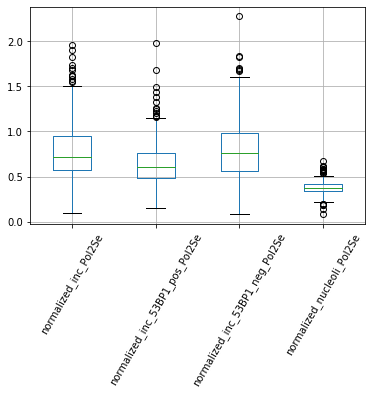

In [38]:
plt.figure();
from matplotlib.pyplot import figure

#figure(figsize=(6, 4), dpi=180)


analysis_df_filtered = analysis_df[analysis_df['normalized_inc_Pol2Se']<5]


axes = analysis_df_filtered.boxplot(column=['normalized_inc_Pol2Se','normalized_inc_53BP1_pos_Pol2Se',
                                      'normalized_inc_53BP1_neg_Pol2Se', 'normalized_nucleoli_Pol2Se'],rot=60,)
                  

In [39]:
analysis_savename = f'measurement_for_all_fov_background_subtracted_{small_53BP_size}_crop_Pol2_analyzed.xlsx'
#analysis_save_path = data_save_folder[:-2] + os.sep + 'analysis' + os.sep + f'{data_name}' 
analysis_save_path = data_save_folder[:-2] + os.sep + 'analysis' + os.sep + data_name.split('_')[0]

analysis_df.to_excel(analysis_save_path+os.sep+analysis_savename)